# 🧪 Classic Super-Resolution Techniques
This notebook presents practical implementations of five classical super-resolution techniques:
1. Bilinear, Bicubic, Area and Lanczos interpolation
2. Iterative Back-Projection (IBP)
3. Non-Local Means Super-Resolution
4. Edge-Guided Interpolation (EGI)
5. Frequency Domain Extrapolation

In [ ]:
import os
import sys
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from SRModels.classic_super_resolution_algorithms.profiling_methods import *
from SRModels.classic_super_resolution_algorithms.classic_algorithms import *
from SRModels.classic_super_resolution_algorithms.visualization_methods import *

## Tracking structures for profiling data

In [2]:
algorithms = ['bilinear','bicubic','area','lanczos','ibp','nlm','egi','freq']

time_stats = {
    'bilinear': [], 'bicubic': [], 'area': [], 'lanczos': [],
    'ibp': [], 'nlm': [], 'egi': [], 'freq': []
}
memory_stats = {k: [] for k in time_stats}
psnr_stats = {k: [] for k in time_stats}
ssim_stats = {k: [] for k in time_stats}
mae_stats = {k: [] for k in time_stats}
rmse_stats = {k: [] for k in time_stats}
throughput_stats = {k: [] for k in time_stats}  # MP/s per image (aún sin poblar)
gradient_mse_stats = {k: [] for k in time_stats}
epi_stats = {k: [] for k in time_stats}
hf_energy_ratio_stats = {k: [] for k in time_stats}
kl_luma_stats = {k: [] for k in time_stats}
kl_color_stats = {k: [] for k in time_stats}

# Time & Memory jitter / variance
time_jitter = {}
time_variance = {}
mem_variance = {}

HF_RADIUS_FRACTION = 0.6  # threshold for high-frequency mask
EPS_NUM = 1e-9

example_index = 0
vis = None         
ibp_example = None 
nlm_example = None 
egi_example = None 
freq_example = None

# Plot colors
colors = {
    'bilinear': '#4c72b0',
    'bicubic':  '#55a868',
    'area':     '#c44e52',
    'lanczos':  '#8172b2',
    'ibp':      '#ccb974',
    'nlm':      '#64b5cd',
    'egi':      '#8c8c8c',
    'freq':     '#937860',
}

# Directory for saving result figures
RESULTS_DIR = Path('classic_algorithms_results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

## Loading dataset

In [3]:
HR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR/low_z_offset"))
LR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR/low_z_offset"))

hr_paths = sorted(glob.glob(os.path.join(HR_DIR, '*.png')))
lr_paths = sorted(glob.glob(os.path.join(LR_DIR, '*.png')))

assert len(hr_paths) == len(lr_paths) and len(hr_paths) > 0, "No HR/LR pairs found or the number does not match"

# Load all images into memory (if possible); otherwise, process in streaming
hr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in hr_paths]
lr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in lr_paths]

## Main Loop

In [4]:
for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    # -------------------- #
    # INTERPOLATION FAMILY #
    # -------------------- #
    h, w = hr_img.shape[:2]

    # Bilinear
    def _bilinear():
        return interpolate_bilinear(lr_img, (w, h))
    bilinear, bilinear_time = time_algorithm(_bilinear)
    _, bilinear_mem = memory_algorithm(_bilinear)
    time_stats['bilinear'].append(bilinear_time)
    memory_stats['bilinear'].append(bilinear_mem)

    # Bicubic
    def _bicubic():
        return interpolate_bicubic(lr_img, (w, h))
    bicubic, bicubic_time = time_algorithm(_bicubic)
    _, bicubic_mem = memory_algorithm(_bicubic)
    time_stats['bicubic'].append(bicubic_time)
    memory_stats['bicubic'].append(bicubic_mem)

    # Area
    def _area():
        return interpolate_area(lr_img, (w, h))
    area, area_time = time_algorithm(_area)
    _, area_mem = memory_algorithm(_area)
    time_stats['area'].append(area_time)
    memory_stats['area'].append(area_mem)

    # Lanczos
    def _lanczos():
        return interpolate_lanczos(lr_img, (w, h))
    lanczos, lanczos_time = time_algorithm(_lanczos)
    _, lanczos_mem = memory_algorithm(_lanczos)
    time_stats['lanczos'].append(lanczos_time)
    memory_stats['lanczos'].append(lanczos_mem)

    # Metrics (color) for interpolation outputs
    hr_f = hr_img.astype(np.float32) / 255.0
    for name, sr_img in [("bilinear", bilinear), ("bicubic", bicubic), ("area", area), ("lanczos", lanczos)]:
        sr_f = sr_img.astype(np.float32) / 255.0
        psnr_stats[name].append(psnr(hr_f, sr_f, data_range=1.0))
        ssim_stats[name].append(ssim(hr_f, sr_f, channel_axis=2, data_range=1.0))
        # Extended metrics (color)
        mae_stats[name].append(mae(hr_img, sr_img))
        rmse_stats[name].append(rmse(hr_img, sr_img))
        gradient_mse_stats[name].append(gradient_mse(hr_img, sr_img))
        epi_stats[name].append(epi(hr_img, sr_img))
        hf_energy_ratio_stats[name].append(
            hf_energy_ratio(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY),
                            radius_frac=HF_RADIUS_FRACTION)
        )
        kl_luma_stats[name].append(
            kl_divergence(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                          cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY))
        )
        kl_color_stats[name].append(kl_divergence_color(hr_img, sr_img))

    # ---------------- #
    # ADVANCED METHODS #
    # ---------------- #
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    # IBP
    def ibp_run():
        return back_projection(hr_g, lr_g, iterations=10)
    ibp_res, ibp_time = time_algorithm(ibp_run)
    _, ibp_mem = memory_algorithm(ibp_run)
    time_stats['ibp'].append(ibp_time)
    memory_stats['ibp'].append(ibp_mem)

    # NLM
    def nlm_run():
        return non_local_means(hr_g, lr_g)
    nlm_res, nlm_time = time_algorithm(nlm_run)
    _, nlm_mem = memory_algorithm(nlm_run)
    time_stats['nlm'].append(nlm_time)
    memory_stats['nlm'].append(nlm_mem)

    # EGI
    def egi_run():
        return edge_guided_interpolation(hr_g, lr_g)
    egi_res, egi_time = time_algorithm(egi_run)
    _, egi_mem = memory_algorithm(egi_run)
    time_stats['egi'].append(egi_time)
    memory_stats['egi'].append(egi_mem)

    # Frequency domain extrapolation
    def freq_run():
        return frequency_extrapolation(hr_g, lr_g)
    freq_res, freq_time = time_algorithm(freq_run)
    _, freq_mem = memory_algorithm(freq_run)
    time_stats['freq'].append(freq_time)
    memory_stats['freq'].append(freq_mem)

    if np.max(freq_res) > 0:
        freq_up_uint8 = (freq_res / np.max(freq_res) * 255.0).astype(np.uint8)
    else:
        freq_up_uint8 = freq_res.astype(np.uint8)

    # Metrics (grayscale) for advanced outputs
    data_range_nlm = hr_g.max() - hr_g.min() if hr_g.max() != hr_g.min() else 255.0
    for name, sr_g in [('ibp', ibp_res), ('nlm', nlm_res), ('egi', egi_res), ('freq', freq_up_uint8)]:
        dr = data_range_nlm if name == 'nlm' else 255.0
        psnr_stats[name].append(psnr(hr_g, sr_g, data_range=dr))
        ssim_stats[name].append(ssim(hr_g, sr_g, data_range=dr))
        mae_stats[name].append(mae(hr_g, sr_g))
        rmse_stats[name].append(rmse(hr_g, sr_g))
        gradient_mse_stats[name].append(gradient_mse(hr_g, sr_g))
        epi_stats[name].append(epi(hr_g, sr_g))
        hf_energy_ratio_stats[name].append(hf_energy_ratio(hr_g, sr_g, radius_frac=HF_RADIUS_FRACTION))
        kl_luma_stats[name].append(kl_divergence(hr_g, sr_g))
        kl_color_stats[name].append(np.nan)  # Not applicable for grayscale

    # Store example artifacts once (chosen by example_index)
    if idx == example_index:
        vis = (hr_img, lr_img, bilinear, bicubic, area, lanczos)
        ibp_example = (hr_g, lr_g, ibp_res)
        nlm_example = (hr_g, nlm_res)
        egi_example = (hr_g, lr_g, egi_res)
        freq_example = (hr_g, freq_up_uint8)

In [5]:
for alg in time_stats.keys():
    t_arr = time_stats.get(alg, [])
    if len(t_arr) > 1 and np.mean(t_arr) > 0:
        time_jitter[alg] = float(np.std(t_arr, ddof=1) / np.mean(t_arr))
        time_variance[alg] = float(np.var(t_arr, ddof=1))
    else:
        time_jitter[alg] = np.nan
        time_variance[alg] = np.nan
        
    m_arr = memory_stats.get(alg, [])
    if len(m_arr) > 1:
        mem_variance[alg] = float(np.var(m_arr, ddof=1))
    else:
        mem_variance[alg] = np.nan

psnr_ci = {alg: bootstrap_ci(vals) for alg, vals in psnr_stats.items()}
ssim_ci = {alg: bootstrap_ci(vals) for alg, vals in ssim_stats.items()}

# --- Build aggregated per-algorithm summary ---
metric_summary = {}
for alg in time_stats.keys():
    time_stats_alg = compute_summary_stats(time_stats.get(alg, []))
    mem_stats_alg = compute_summary_stats(memory_stats.get(alg, []))
    psnr_stats_alg = compute_summary_stats(psnr_stats.get(alg, []))
    ssim_stats_alg = compute_summary_stats(ssim_stats.get(alg, []))
    mae_stats_alg = compute_summary_stats(mae_stats.get(alg, []))
    rmse_stats_alg = compute_summary_stats(rmse_stats.get(alg, []))
    grad_stats_alg = compute_summary_stats(gradient_mse_stats.get(alg, []))
    epi_stats_alg = compute_summary_stats(epi_stats.get(alg, []))
    hf_stats_alg = compute_summary_stats(hf_energy_ratio_stats.get(alg, []))
    kl_luma_stats_alg = compute_summary_stats(kl_luma_stats.get(alg, []))
    kl_color_stats_alg = compute_summary_stats(kl_color_stats.get(alg, []))

    metric_summary[alg] = {
        'psnr_mean': psnr_stats_alg['mean'],
        'psnr_var': psnr_stats_alg['var'],
        'psnr_max': psnr_stats_alg['max'],
        'psnr_ci_low': psnr_ci[alg][0],
        'psnr_ci_high': psnr_ci[alg][1],
        'ssim_mean': ssim_stats_alg['mean'],
        'ssim_var': ssim_stats_alg['var'],
        'ssim_max': ssim_stats_alg['max'],
        'ssim_ci_low': ssim_ci[alg][0],
        'ssim_ci_high': ssim_ci[alg][1],
        'time_mean': time_stats_alg['mean'],
        'time_max': time_stats_alg['max'],
        'time_jitter': time_jitter[alg],
        'time_var': time_variance[alg],
        'memory_mean': mem_stats_alg['mean'],
        'memory_max': mem_stats_alg['max'],
        'memory_var': mem_variance[alg],
        'mae_mean': mae_stats_alg['mean'],
        'rmse_mean': rmse_stats_alg['mean'],
        'grad_mse_mean': grad_stats_alg['mean'],
        'epi_mean': epi_stats_alg['mean'],
        'hf_ratio_mean': hf_stats_alg['mean'],
        'kl_luma_mean': kl_luma_stats_alg['mean'],
        'kl_color_mean': kl_color_stats_alg['mean'],
    }

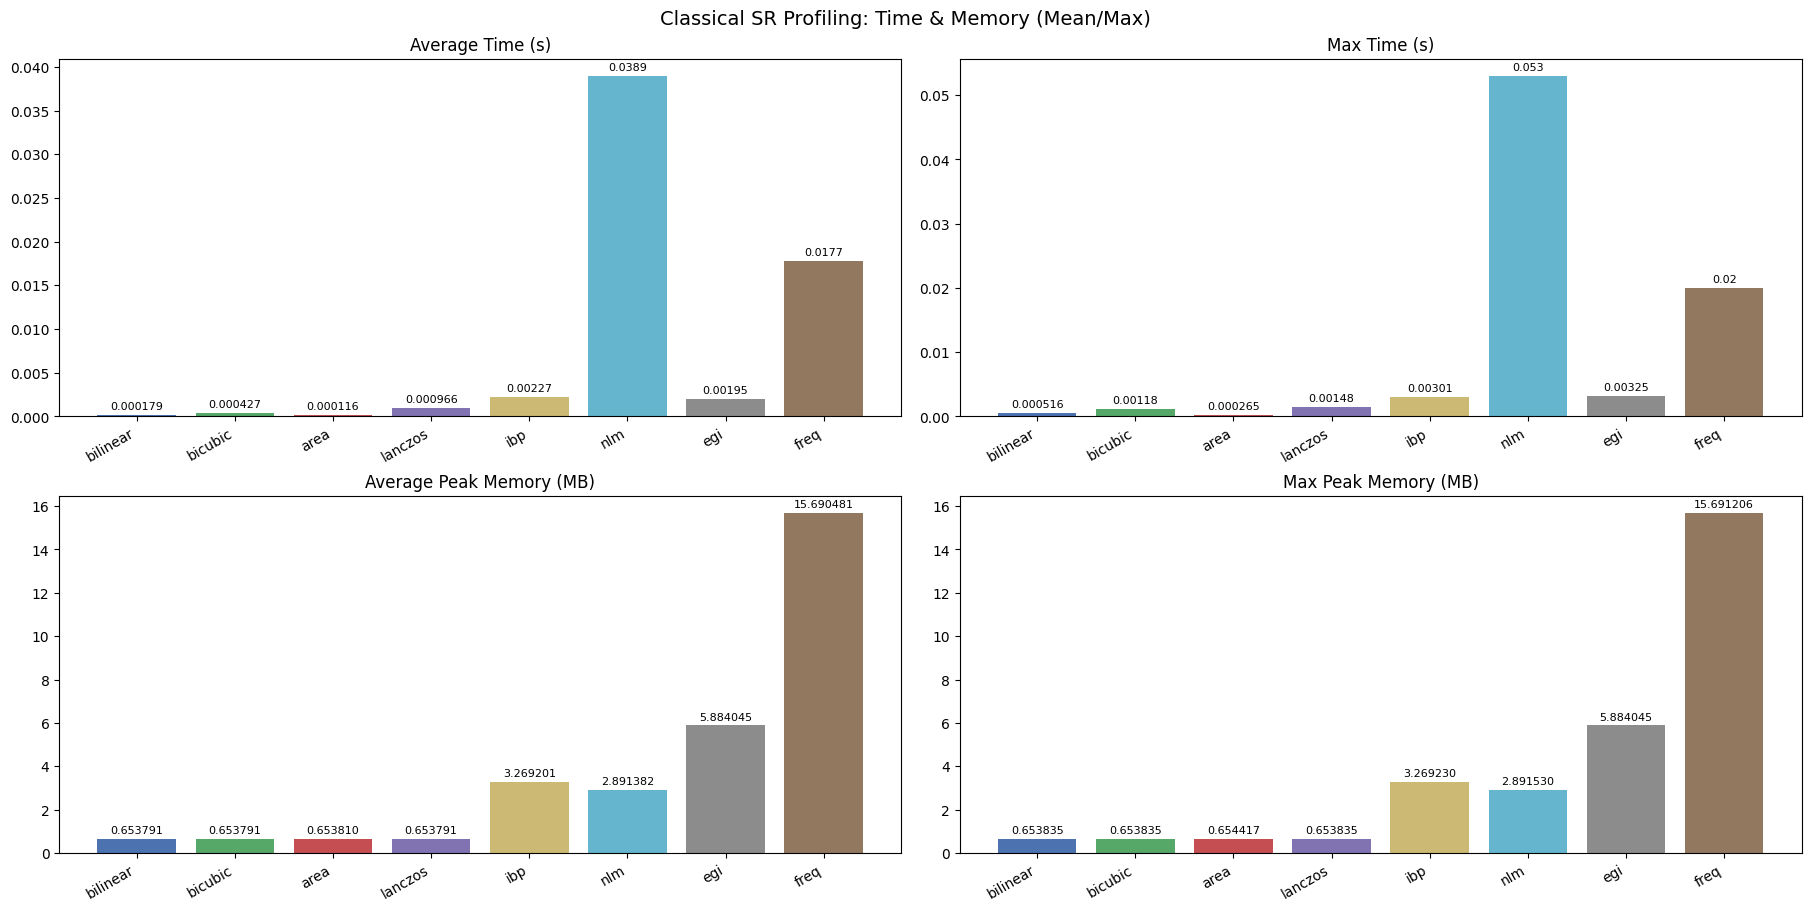

In [7]:
plot_time_memory_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR Profiling: Time & Memory (Mean/Max)',
    outfile=RESULTS_DIR / 'time_memory_summary.png',
    figsize=(18, 9)
)

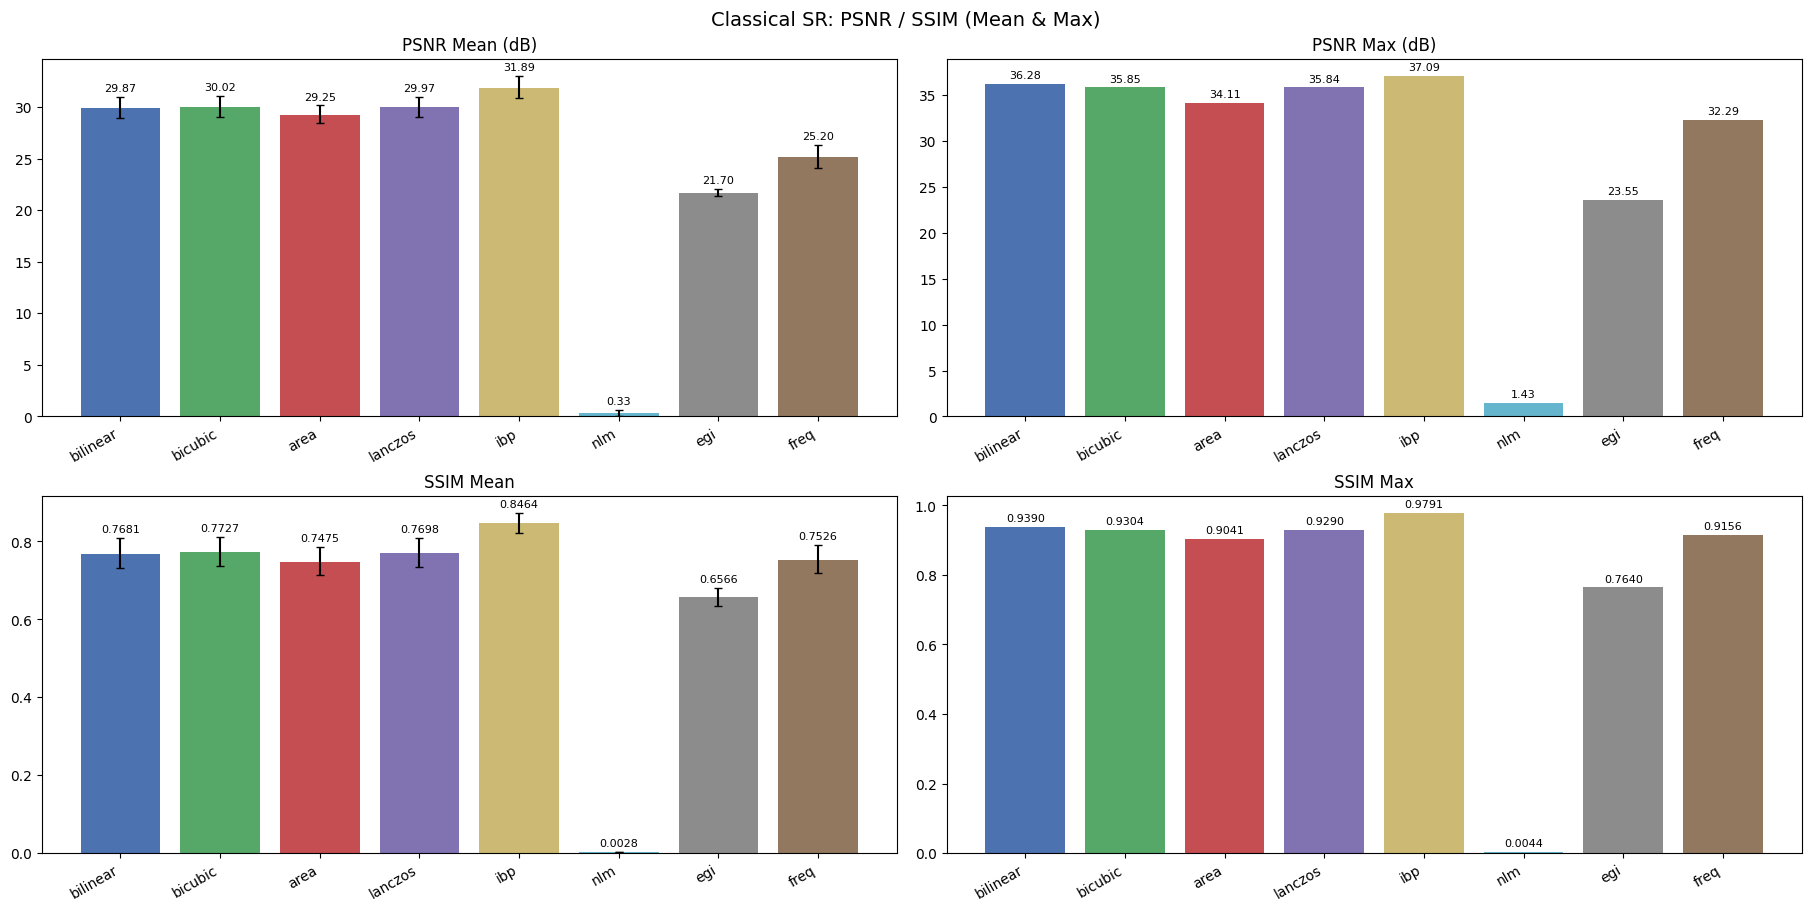

In [8]:
plot_psnr_ssim_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR: PSNR / SSIM (Mean & Max)',
    outfile=RESULTS_DIR / 'psnr_ssim_summary.png',
    figsize=(18, 9)
)

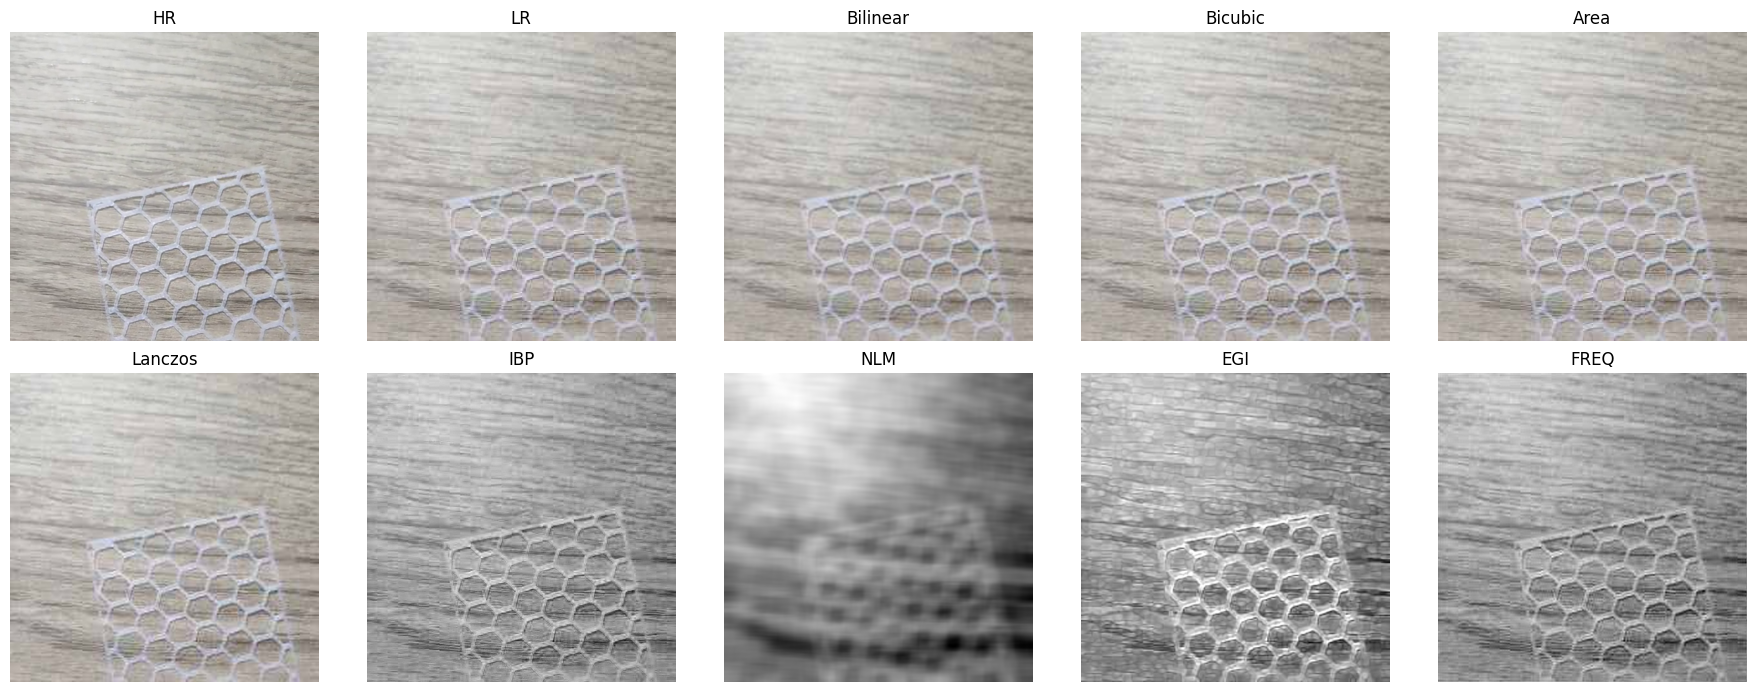

In [9]:
hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v = vis
hr_g_v, lr_g_v, ibp_v = ibp_example
hr_v, nlm_v = nlm_example
hr_egi_v, lr_egi_v, egi_v = egi_example
hr_freq_v, freq_v = freq_example

def to_display(img):
    if img.ndim == 2:
        return img if img.dtype != np.float32 else np.clip(img,0,1)
    return img

images = [
    ('HR', hr_img_v),
    ('LR', lr_img_v),
    ('Bilinear', bilinear_v),
    ('Bicubic', bicubic_v),
    ('Area', area_v),
    ('Lanczos', lanczos_v),
    ('IBP', ibp_v),
    ('NLM', nlm_v if nlm_v.ndim==3 else nlm_v),
    ('EGI', egi_v),
    ('FREQ', freq_v),
]

plt.figure(figsize=(18,7))

for i, (title, img) in enumerate(images, start=1):
    plt.subplot(2,5,i)
    cmap = 'gray' if img.ndim==2 else None
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
out_grid = RESULTS_DIR / 'super_resolution_example.png'
plt.savefig(out_grid, dpi=150)

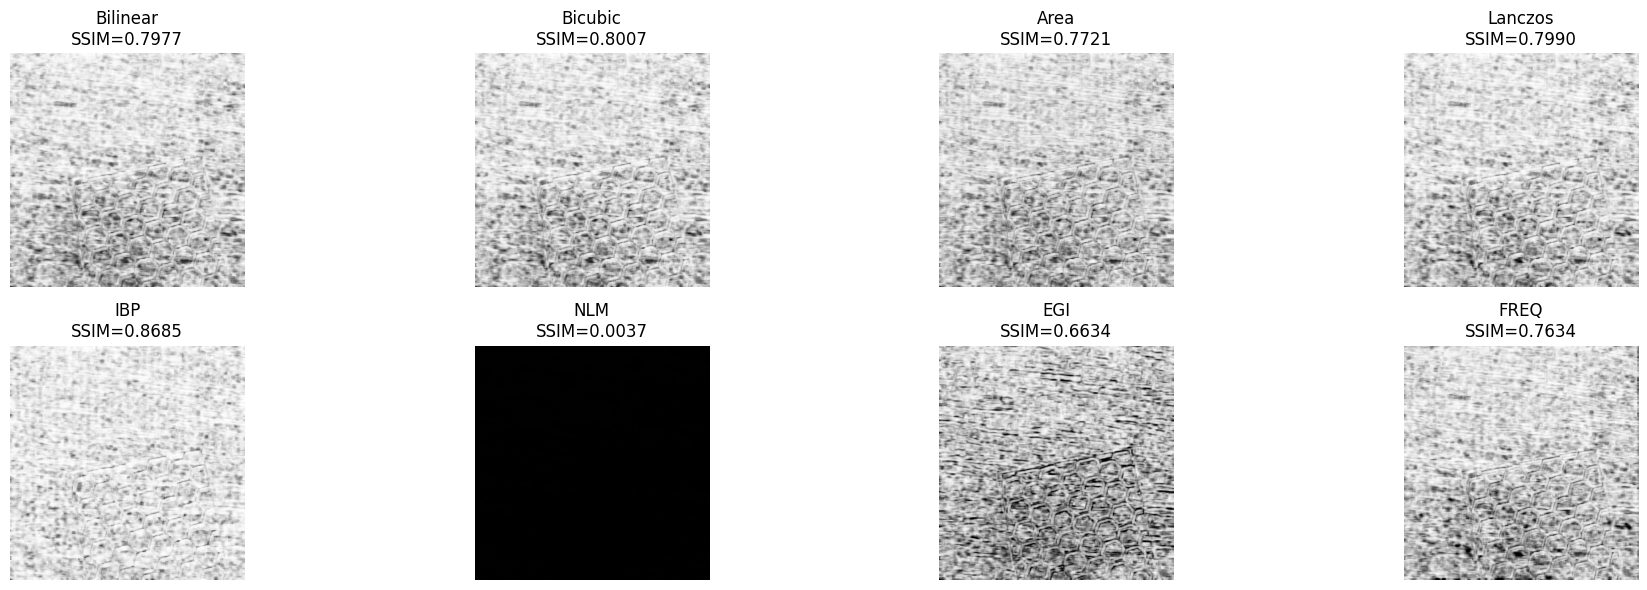

In [10]:
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if img.ndim == 3 else img

hr_img_v, lr_img_v, bilinear_v, bicubic_v, area_v, lanczos_v = vis
hr_g_v, lr_g_v, ibp_v = ibp_example
hr_v, nlm_v = nlm_example
hr_egi_v, lr_egi_v, egi_v = egi_example
hr_freq_v, freq_v = freq_example

# Lista completa de pares (nombre, HR, SR) en el orden requerido
pairs = [
    ('Bilinear', to_gray(hr_img_v), to_gray(bilinear_v)),
    ('Bicubic',  to_gray(hr_img_v), to_gray(bicubic_v)),
    ('Area',     to_gray(hr_img_v), to_gray(area_v)),
    ('Lanczos',  to_gray(hr_img_v), to_gray(lanczos_v)),
    ('IBP',      hr_g_v, ibp_v),
    ('NLM',      hr_v, nlm_v if nlm_v.ndim==2 else cv2.cvtColor(nlm_v, cv2.COLOR_RGB2GRAY)),
    ('EGI',      hr_egi_v, egi_v),
    ('FREQ',     hr_freq_v, freq_v),
]

ssim_maps = []
titles = []
for name, hr_g, sr_g in pairs:
    data_range = 255 if hr_g.dtype != np.float32 else 1.0
    val, ssim_map = ssim(hr_g, sr_g, data_range=data_range, full=True)
    ssim_maps.append((ssim_map, val))
    titles.append(name)

plt.figure(figsize=(20,6))
for i, ((ssim_map, val), name) in enumerate(zip(ssim_maps, titles), start=1):
    plt.subplot(2,4,i)
    plt.imshow(ssim_map, cmap='gray', vmin=0, vmax=1)
    plt.title(f"{name}\nSSIM={val:.4f}")
    plt.axis('off')
plt.tight_layout()
out_diff = RESULTS_DIR / 'ssim_similarity_maps.png'
plt.savefig(out_diff, dpi=150)

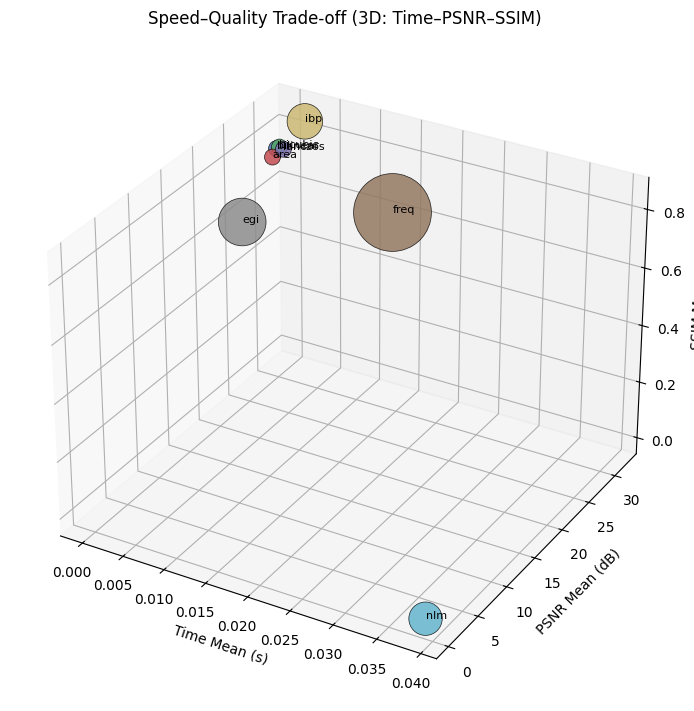

In [11]:
# 3D Speed–Quality Trade-off: X=Time, Y=PSNR, Z=SSIM; marker size ∝ memory
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 - enables 3D projection
import matplotlib.pyplot as plt

# Prepare data
x_time = [metric_summary[a]['time_mean'] for a in algorithms]
y_psnr = [metric_summary[a]['psnr_mean'] for a in algorithms]
z_ssim = [metric_summary[a]['ssim_mean'] for a in algorithms]
sizes = [max(20, 200 * (metric_summary[a]['memory_mean'] / (1024**2 + 1e-9))) for a in algorithms]  # scale by MB
color_list = [colors[a] for a in algorithms]

# Plot 3D scatter
fig = plt.figure(figsize=(9, 7), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_time, y_psnr, z_ssim, s=sizes, c=color_list, alpha=0.85, edgecolors='k', linewidth=0.5)

# Labels and titles
ax.set_xlabel('Time Mean (s)')
ax.set_ylabel('PSNR Mean (dB)')
ax.set_zlabel('SSIM Mean')
ax.set_title('Speed–Quality Trade-off (3D: Time–PSNR–SSIM)')

# Annotate each point with algorithm name
for a, x, y, z in zip(algorithms, x_time, y_psnr, z_ssim):
    ax.text(x, y, z, a, fontsize=8)

plt.show()

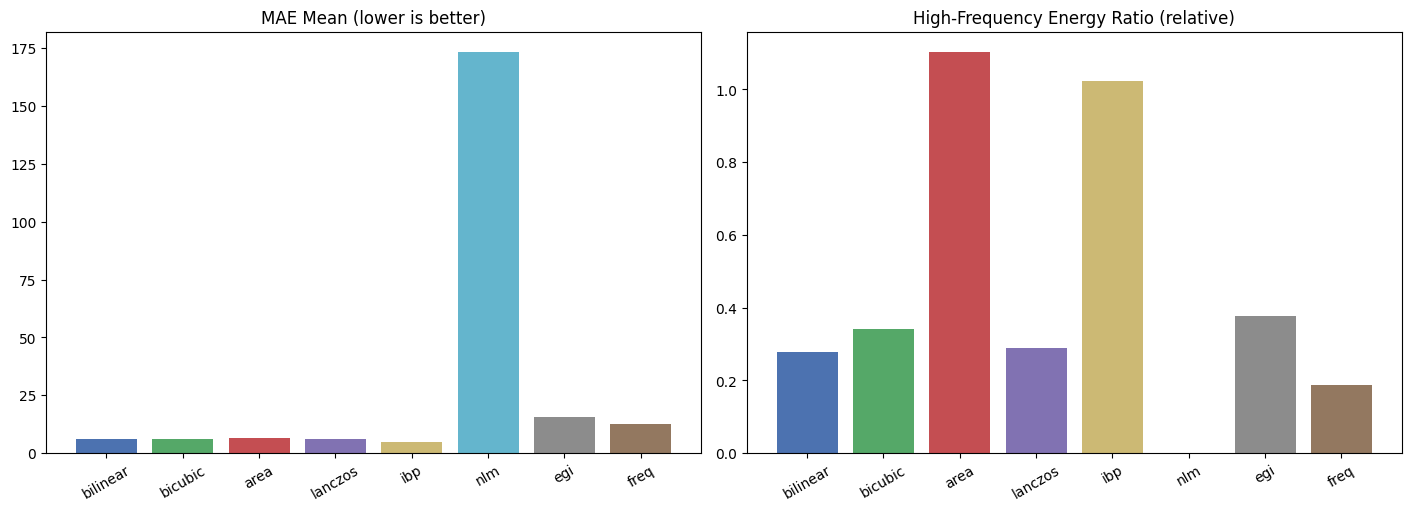

In [12]:
to_arr = lambda k: [metric_summary[a][k] for a in algorithms]
fig, ax = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Error-based
ax[0].bar(algorithms, to_arr('mae_mean'), color=[colors[a] for a in algorithms])
ax[0].set_title('MAE Mean (lower is better)')
ax[0].tick_params(axis='x', rotation=30)

# Perceptual proxies (pick one you trust most)
ax[1].bar(algorithms, to_arr('hf_ratio_mean'), color=[colors[a] for a in algorithms])
ax[1].set_title('High-Frequency Energy Ratio (relative)')
ax[1].tick_params(axis='x', rotation=30)

plt.show()